In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("data/train_processed.csv")

train["price"] = np.expm1(train["price_log"])


# Distribution of Property Prices

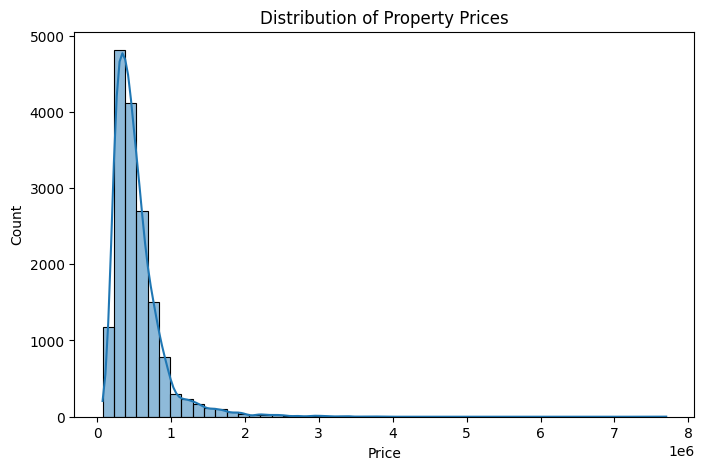

In [3]:
plt.figure(figsize=(8,5))
sns.histplot(train["price"], bins=50, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


# Price vs Latitude / Longitude Scatter

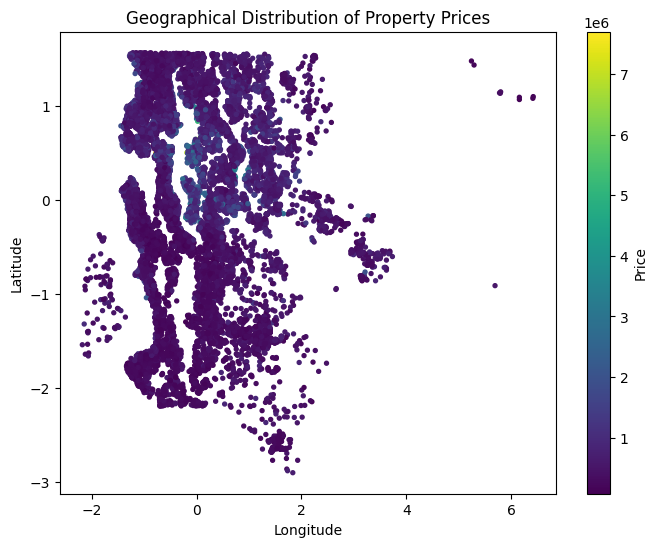

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(
    train["long"],
    train["lat"],
    c=train["price"],
    cmap="viridis",
    s=8
)
plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Property Prices")
plt.show()


# High-Price vs. Low-Price Clusters

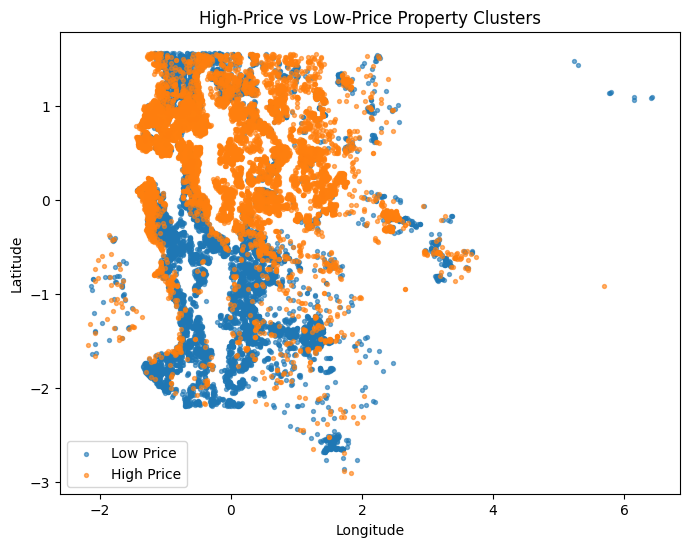

In [9]:
threshold = train["price"].median()

plt.figure(figsize=(8,6))
plt.scatter(
    train[train["price"] <= threshold]["long"],
    train[train["price"] <= threshold]["lat"],
    s=8,
    label="Low Price",
    alpha=0.6
)

plt.scatter(
    train[train["price"] > threshold]["long"],
    train[train["price"] > threshold]["lat"],
    s=8,
    label="High Price",
    alpha=0.6
)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("High-Price vs Low-Price Property Clusters")
plt.show()


# Price Heatmap Over Map (2D Density)

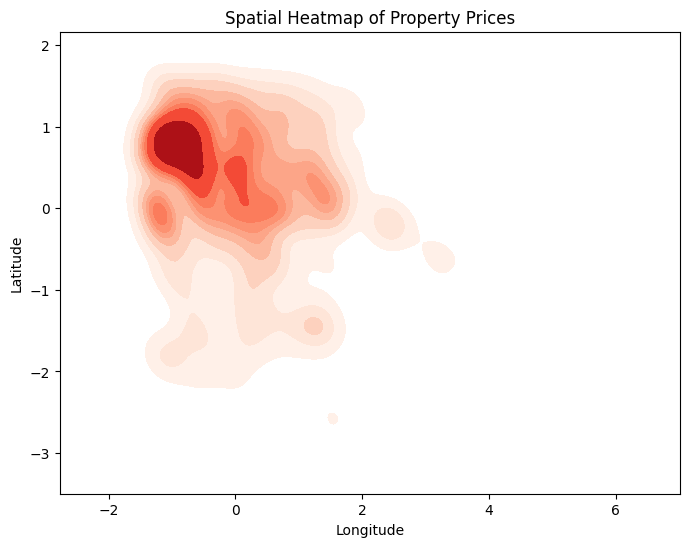

In [6]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=train["long"],
    y=train["lat"],
    weights=train["price"],
    cmap="Reds",
    fill=True,
    thresh=0.05
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Heatmap of Property Prices")
plt.show()


In [7]:
train[['lat','long','price']].corr()


,lat,long,price
lat,1.000000,-0.140838,0.310008
long,-0.140838,1.000000,0.024279
price,0.310008,0.024279,1.000000


In [10]:
train[['sqft_living15','price']].corr()


,sqft_living15,price
sqft_living15,1.000000,0.581781
price,0.581781,1.000000


# GRAD CAM EXPLAINABILITY

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(weights="IMAGENET1K_V1")
        self.cnn.fc = nn.Identity()

    def forward(self, x):
        return self.cnn(x)

class TabularEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class MultimodalModel(nn.Module):
    def __init__(self, tab_dim):
        super().__init__()
        self.img_enc = ImageEncoder()
        self.tab_enc = TabularEncoder(tab_dim)

        self.regressor = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, img, tab):
        img_feat = F.normalize(self.img_enc(img), dim=1)
        tab_feat = self.tab_enc(tab)
        x = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(x)


In [83]:
FEATURES = ['bedrooms', 'bathrooms', 'sqft_living', 'lat', 'long']

model = MultimodalModel(len(FEATURES))
model.load_state_dict(
    torch.load("outputs/multimodal_model.pth", map_location="cpu"),
    strict=False
)
model.eval()



MultimodalModel(
  (img_enc): ImageEncoder(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): 

# Building Grad-CAM CNN

In [84]:
cnn_model = model.img_enc.cnn
cnn_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Load Image

In [85]:
img_path = f"images/train/{train.iloc[0].id}.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

img_norm = img.astype(np.float32) / 255.0

input_tensor = (
    torch.from_numpy(img_norm)
    .permute(2, 0, 1)
    .unsqueeze(0)
)


# Grad-CAM

In [86]:
target_layers = [cnn_model.layer4]

cam = GradCAM(
    model=cnn_model,
    target_layers=target_layers
)

targets = [ClassifierOutputTarget(0)]  

grayscale_cam = cam(
    input_tensor=input_tensor,
    targets=targets
)[0]


In [88]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

cam_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


In [89]:
class MultimodalWrapper(nn.Module):
    def __init__(self, model, fixed_tab):
        super().__init__()
        self.model = model
        self.fixed_tab = fixed_tab

    def forward(self, x):
        return self.model(x, self.fixed_tab)


# Low/Mid/High Price Classification of samples

In [91]:
low_row = train.loc[train['price'] < train['price'].quantile(0.25)].iloc[0]
mid_row = train.loc[
    (train['price'] > train['price'].quantile(0.45)) &
    (train['price'] < train['price'].quantile(0.55))
].iloc[0]
high_row = train.loc[train['price'] > train['price'].quantile(0.75)].iloc[0]

samples = [low_row, mid_row, high_row]
labels  = ["Low-priced", "Mid-priced", "High-priced"]


In [92]:
target_layers = [model.img_enc.cnn.layer4]


In [93]:
def generate_gradcam(row, label):
    
    tab_np = row[FEATURES].to_numpy(dtype=np.float32)
    tab = torch.tensor(tab_np).unsqueeze(0).to(device)

    wrapped_model = MultimodalWrapper(model, tab)
    wrapped_model.eval()

    cam = GradCAM(
        model=wrapped_model,
        target_layers=[model.img_enc.cnn.layer4]
    )

    
    img_path = f"images/train/{int(row.id)}.png"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_float = img.astype(np.float32) / 255.0
    input_tensor = cam_transform(img).unsqueeze(0).to(device)

    # Grad-CAM
    grayscale_cam = cam(
        input_tensor=input_tensor,
        eigen_smooth=True,
        aug_smooth=True
    )[0]

    
    visualization = show_cam_on_image(
    img_float,
    grayscale_cam,
    use_rgb=True,
    image_weight=0.7 
    )


    return visualization, row.price, row.id, label


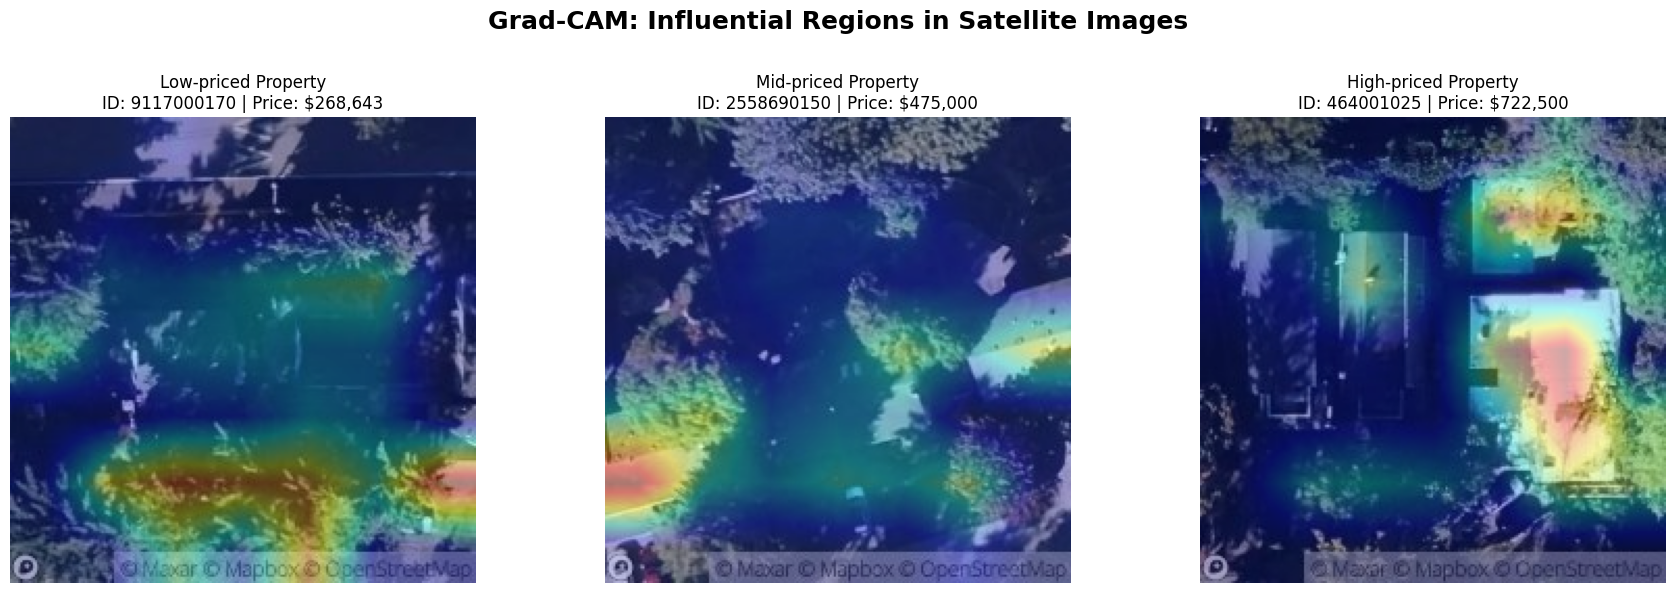

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, row, label in zip(axes, samples, labels):
    cam_img, price, pid, lbl = generate_gradcam(row, label)

    ax.imshow(cam_img)
    ax.axis("off")
    ax.set_title(
        f"{lbl} Property\nID: {int(pid)} | Price: ${price:,.0f}",
        fontsize=12
    )

plt.suptitle(
    "Grad-CAM: Influential Regions in Satellite Images",
    fontsize=18,
    fontweight="bold",
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.92]) 
plt.show()

